In [1]:
#Neural Style Transfer: 
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# Set up environment variables for TensorFlow Hub models
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

class NeuralStyleTransfer:
    def __init__(self, content_path, style_path, content_layers, style_layers,
                 style_weight=1e-2, content_weight=1e4, total_variation_weight=30,
                 optimizer='adam', learning_rate=0.02):
        self.content_path = content_path
        self.style_path = style_path
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.total_variation_weight = total_variation_weight
        self.learning_rate = learning_rate
        self.optimizer = self._get_optimizer(optimizer)
        self.content_image = self.load_img(content_path)
        self.style_image = self.load_img(style_path)
        self.image = tf.Variable(self.content_image)
        self.extractor = self._build_extractor()

    def _get_optimizer(self, optimizer_name):
        if optimizer_name.lower() == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.99, epsilon=1e-1)
        # Add other optimizers here
        else:
            raise ValueError("Optimizer not supported")

    @staticmethod
    def load_img(path_to_img):
        max_dim = 128
        img = tf.io.read_file(path_to_img)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img

    @staticmethod
    def tensor_to_image(tensor):
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return PIL.Image.fromarray(tensor)

    @staticmethod
    def vgg_layers(layer_names):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in layer_names]
        model = tf.keras.Model([vgg.input], outputs)
        return model

    def _build_extractor(self):
        class StyleContentModel(tf.keras.models.Model):
            def __init__(self, style_layers, content_layers):
                super(StyleContentModel, self).__init__()
                self.vgg = NeuralStyleTransfer.vgg_layers(style_layers + content_layers)
                self.style_layers = style_layers
                self.content_layers = content_layers
                self.num_style_layers = len(style_layers)
                self.vgg.trainable = False

            def call(self, inputs):
                inputs = inputs * 255.0
                preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
                outputs = self.vgg(preprocessed_input)
                style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                                  outputs[self.num_style_layers:])

                style_outputs = [self.gram_matrix(style_output)
                                 for style_output in style_outputs]

                content_dict = {content_name: value
                                for content_name, value
                                in zip(self.content_layers, content_outputs)}

                style_dict = {style_name: value
                              for style_name, value
                              in zip(self.style_layers, style_outputs)}

                return {'content': content_dict, 'style': style_dict}

            @staticmethod
            def gram_matrix(input_tensor):
                result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
                input_shape = tf.shape(input_tensor)
                num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
                return result / (num_locations)

        return StyleContentModel(self.style_layers, self.content_layers)


    def clip_0_1(self, image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.extractor(self.style_image)['style'][name]) ** 2)
                            for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.extractor.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.extractor(self.content_image)['content'][name]) ** 2)
                                for name in content_outputs.keys()])
        content_loss *= self.content_weight / len(self.content_layers)
        loss = style_loss + content_loss
        return loss


In [2]:
import csv
import os
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import numpy as np
import PIL.Image
import time

class NeuralStyleTransferLogging(NeuralStyleTransfer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logs = []  # To store logs for CSV
    
    @tf.function()
    def train_step(self):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.image)
            loss = self.style_content_loss(outputs)
            total_variation_loss = self.total_variation_weight * tf.image.total_variation(self.image)
            total_loss = loss + total_variation_loss
        grad = tape.gradient(total_loss, self.image)
        self.optimizer.apply_gradients([(grad, self.image)])
        self.image.assign(self.clip_0_1(self.image))
        # Directly return the TensorFlow tensors
        return total_loss, loss, total_variation_loss

    def run_style_transfer(self, epochs=10, steps_per_epoch=100, csv_filename='style_transfer_logs.csv', final_image_path='final_stylized_image.png'):
        start = time.time()
        loss_values = []
        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                total_loss, style_loss, content_loss = self.train_step()
                # Ensure conversion is done outside @tf.function
                if tf.executing_eagerly():
                    total_loss, style_loss, content_loss = total_loss.numpy(), style_loss.numpy(), content_loss.numpy()
                print(f"Epoch {epoch+1}/{epochs}, Step {step+1}/{steps_per_epoch}, Total Loss: {total_loss}")
                loss_values.append([epoch+1, step+1, total_loss, style_loss, content_loss])
            
            # Optionally, display the current stylized image every epoch
            display.clear_output(wait=True)
            display.display(self.tensor_to_image(self.image))

        end = time.time()
        print("Total time: {:.1f}".format(end - start))

        # Save the final stylized image to the specified path.
        final_image = self.tensor_to_image(self.image)
        final_image.save(final_image_path)
        print(f"Final stylized image saved to {final_image_path}")

        # Write the logs to a CSV file
        with open(csv_filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Step", "Total Loss", "Style Loss", "Content Loss"])
            writer.writerows(loss_values)

In [6]:
# Define the paths to the content and style images
content_path = 'images\YellowLabradorLooking_new.jpg'
style_path = 'images\Vassily_Kandinsky_1913_-_Composition_7.jpg'

# Define the content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [ ]:
# Define the paths to the content and style images
content_path = 'images\YellowLabradorLooking_new.jpg'
style_path = 'images\Vassily_Kandinsky_1913_-_Composition_7.jpg'

# Define the content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# Experiment 1: Low Style Weight
nst_low_style_weight = NeuralStyleTransferLogging(content_path=content_path,
                                           style_path=style_path,
                                           content_layers=content_layers,
                                           style_layers=style_layers,
                                           style_weight=1e-4,  # Low style weight
                                           content_weight=1e4)

# Experiment 2: Medium Style Weight
nst_medium_style_weight = NeuralStyleTransferLogging(content_path=content_path,
                                              style_path=style_path,
                                              content_layers=content_layers,
                                              style_layers=style_layers,
                                              style_weight=1e-2,  # Medium style weight
                                              content_weight=1e4)


# Experiment 3: High Style Weight
nst_high_style_weight = NeuralStyleTransferLogging (content_path=content_path,
                                            style_path=style_path,
                                            content_layers=content_layers,
                                            style_layers=style_layers,
                                            style_weight=1e+2,  # High style weight
                                            content_weight=1e4)

# Experiment 1: Low Style Weight
print("Starting Experiment 1: Low Style Weight")
final_image_path_1 = 'final_images/final_image_low_style.png'  # Specify unique final image path
nst_low_style_weight.run_style_transfer(epochs=4, steps_per_epoch=100, final_image_path=final_image_path_1)

# Experiment 2: Medium Style Weight
print("\nStarting Experiment 2: Medium Style Weight")
final_image_path_2 = 'final_images/final_image_medium_style.png'  # Specify unique final image path
nst_medium_style_weight.run_style_transfer(epochs=4, steps_per_epoch=100, final_image_path=final_image_path_2)

# Experiment 3: High Style Weight
print("\nStarting Experiment 3: High Style Weight")
final_image_path_3 = 'final_images/final_image_high_style.png'  # Specify unique final image path
nst_high_style_weight.run_style_transfer(epochs=4, steps_per_epoch=100, final_image_path=final_image_path_3)




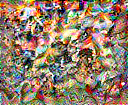

Total time: 177.5
Final stylized image saved to final_images/final_image_low_style.png


In [8]:
# Experiment 4: Med-high Style Weight
nst_one_style_weight = NeuralStyleTransferLogging(content_path=content_path,
                                           style_path=style_path,
                                           content_layers=content_layers,
                                           style_layers=style_layers,
                                           style_weight=1,  # 1s
                                           content_weight=1e4)
# Experiment 4: Med-high Style Weight
print("Starting Experiment 1: Low Style Weight")
final_image_path_1 = 'final_images/final_image_low_style.png'  # Specify unique final image path
nst_one_style_weight.run_style_transfer(epochs=4, steps_per_epoch=100, final_image_path=final_image_path_1)
